<a href="https://colab.research.google.com/github/harsh-s15/Speech-Emotion-DL/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prasodic Feature extraction resulted in 180 features for analysis.**
---

---
We now explore and evaluate their performance on a few standard classifiers.

In [ ]:
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score as acc

In [ ]:
from IPython.lib.display import Audio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
root = r'/content/drive/MyDrive/ser_updated/speech-emotion-recognition-ravdess-data/'

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions = emotions.values()

In [ ]:
def extractFeature(file_name, mfcc=True, chroma=True, mel=True):
    X,sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

In [ ]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob(root + r'/Actor_*/*'):
        file_name=os.path.basename(file)
        # print(file_name)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature= extractFeature(file, mfcc=True, chroma=True, mel=False)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
def showConfMatrix(y_test,y_pred):
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                                            colorbar=False,
                                            cmap=plt.cm.Blues,
                                            xticks_rotation=45)

### **MLP - Multi Layer perceptron**

training Accuracy: 100.00 %
testing Accuracy: 65.28 %


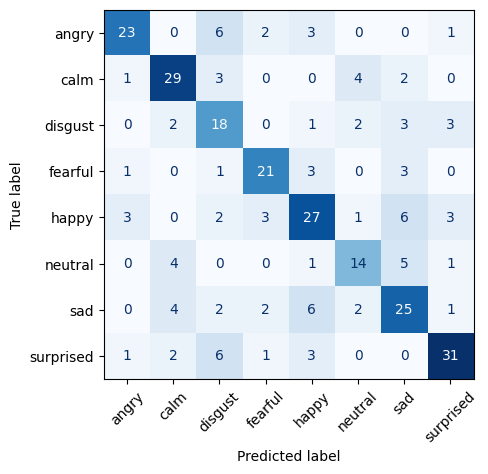

In [ ]:
#logistic
model=MLPClassifier(alpha=0.01,
                    batch_size=256, 
                    epsilon=1e-08, 
                    hidden_layer_sizes=(300,), 
                    learning_rate='adaptive', 
                    activation='logistic',
                    max_iter=500)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

training Accuracy: 58.59 %
testing Accuracy: 41.67 %


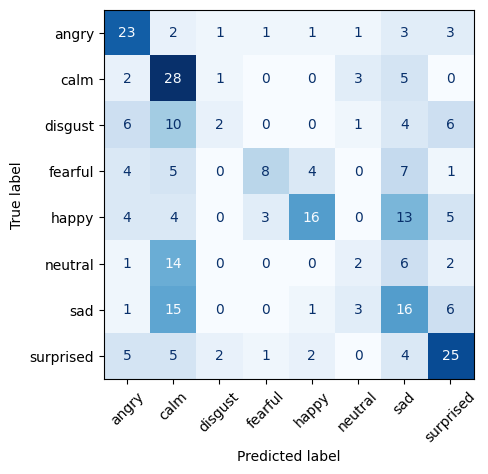

In [ ]:
# ReLU
model=MLPClassifier(alpha=0.01,
                    batch_size=256, 
                    epsilon=1e-08, 
                    hidden_layer_sizes=(300,), 
                    learning_rate='adaptive', 
                    activation='relu',
                    max_iter=500)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

training Accuracy: 100.00 %
testing Accuracy: 57.29 %


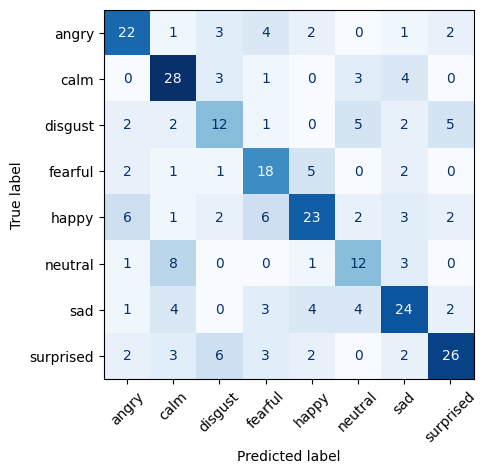

In [ ]:
# tanh
model=MLPClassifier(alpha=0.01,
                    batch_size=256, 
                    epsilon=1e-08, 
                    hidden_layer_sizes=(300,), 
                    learning_rate='adaptive', 
                    activation='tanh',
                    max_iter=500)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

training Accuracy: 53.30 %
testing Accuracy: 39.24 %


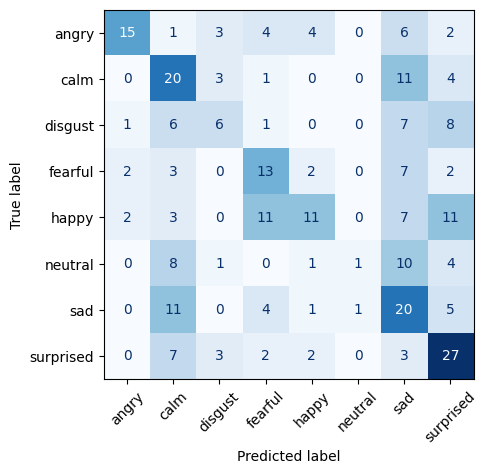

In [ ]:
# identity
model=MLPClassifier(alpha=0.01,
                    batch_size=256, 
                    epsilon=1e-08, 
                    hidden_layer_sizes=(300,), 
                    learning_rate='adaptive', 
                    activation='identity',
                    max_iter=500)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

### **Random Forest Classifier**

training Accuracy: 100.00 %
testing Accuracy: 46.18 %


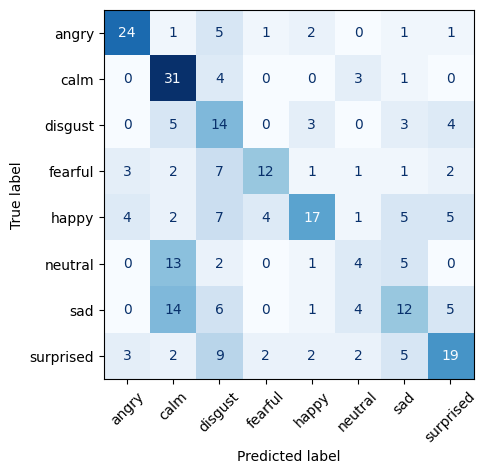

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc
model = rfc()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

### **SVM**

training Accuracy: 29.77 %
testing Accuracy: 26.04 %


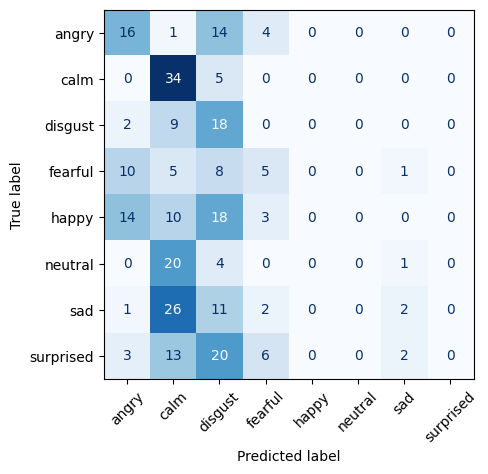

In [ ]:
from sklearn.svm import SVC 
model = SVC()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

### `We find that emotions 'anger','calm','disgust' and 'fearful' are highly distinguishable and separable.`


--- 
We refine our dataset to include only these labels and compare the results.

In [ ]:
observed_emotions=['calm', 'angry', 'fearful', 'disgust']
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

---
SVC

training Accuracy: 54.07 %
testing Accuracy: 53.25 %


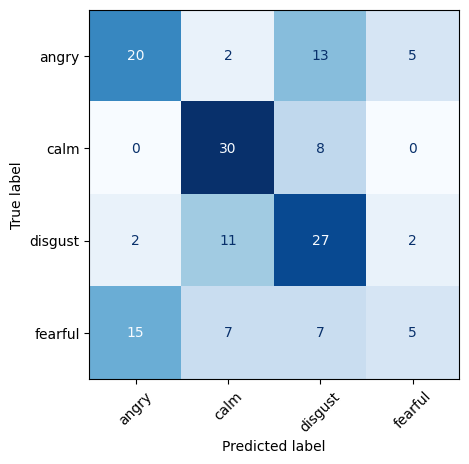

In [ ]:
model = SVC()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

---
RFC

training Accuracy: 100.00 %
testing Accuracy: 70.78 %


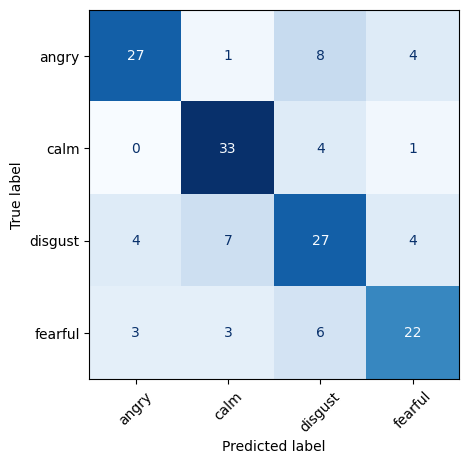

In [ ]:
model = rfc()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

---
MLP (logistic)

training Accuracy: 100.00 %
testing Accuracy: 84.42 %


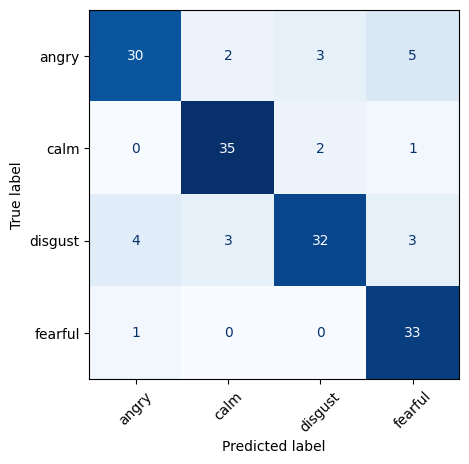

In [ ]:
model=MLPClassifier(alpha=0.01,
                    batch_size=256, 
                    epsilon=1e-08, 
                    hidden_layer_sizes=(300,), 
                    learning_rate='adaptive', 
                    activation='logistic',
                    max_iter=500)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("training Accuracy: {:.2f} %".format(acc(model.predict(x_train),y_train)*100))
print("testing Accuracy: {:.2f} %".format(acc(y_pred,y_test)*100))
showConfMatrix(y_test,y_pred)

### `MLP with logistic activation has provided best results so far in terms of both - generalisability and accuracy`

# Record audio from your microphone

---
original functionality referred to from : [here](https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb)

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def hearAndPredict():
    audio, sr = get_audio()

    X = audio.astype(np.float32)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T, axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sr).T,axis=0)
    result=np.hstack((result, mel))

    print(model.predict([result]))

In [ ]:
hearAndPredict()